In [1]:
!pip install pyswarm --quiet
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

Stopping search: Swarm best position change less than 1e-08
Best validation MSE: 59.48117849472938
Best PSO params: [5.00000000e+00 6.97473770e+01 7.68866567e-03 1.04951898e-01
 3.84585128e-03]
Held-out Test RMSE: 24.881205344109514


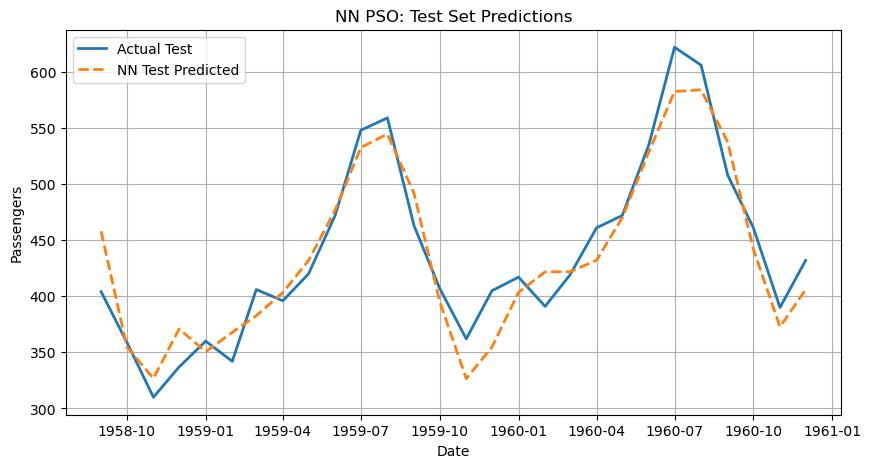

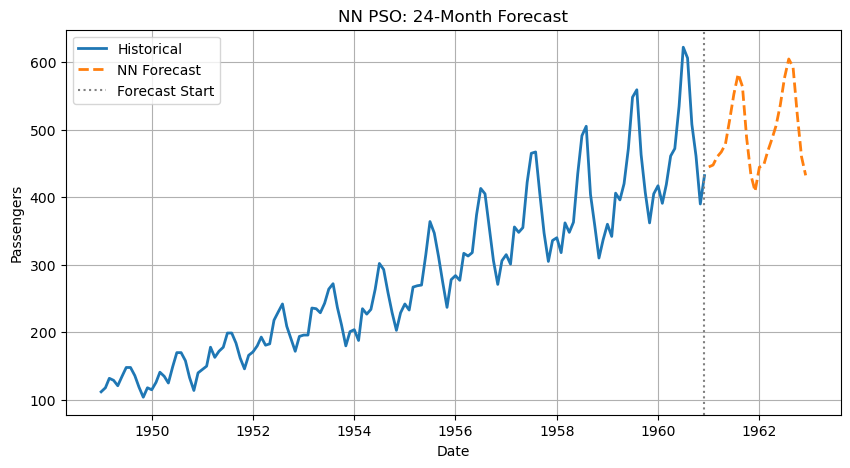

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pyswarm import pso
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month').rename(columns={'#Passengers':'Passengers'})

# Feature engineering
def create_robust_features(data, n_lags=6):
    df = data.copy()
    for i in range(1, n_lags+1):
        df[f'lag_{i}'] = df['Passengers'].shift(i)
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.index.month/12)
    df['rolling_mean_3'] = df['Passengers'].rolling(3, min_periods=1).mean()
    df['rolling_mean_6'] = df['Passengers'].rolling(6, min_periods=1).mean()
    df['yoy_change'] = df['Passengers'].pct_change(12).fillna(0)
    df['trend'] = (np.arange(len(df)) - len(df)/2)/len(df)
    return df.dropna()

# Build feature matrix
df = create_robust_features(data)
X_all = df.drop('Passengers', axis=1).values
y_all = df['Passengers'].values

# Split: train (60%), validation (20%), test (20%)
n = len(X_all)
train_end = int(0.6*n)
val_end   = int(0.8*n)
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
X_test,  y_test  = X_all[val_end:], y_all[val_end:]

# Scale features and target
def fit_scalers(X, y):
    sx = StandardScaler().fit(X)
    sy = StandardScaler().fit(y.reshape(-1,1))
    return sx, sy

scaler_X, scaler_y = fit_scalers(X_train, y_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)
y_train_s = scaler_y.transform(y_train.reshape(-1,1)).ravel()

# Neural network constructor
def create_nn(params):
    h1 = max(5, min(100, int(params[0])))
    h2 = max(5, min(100, int(params[1])))
    lr = max(0.001, min(0.01, params[2]))
    mom= max(0.1,   min(0.9,  params[3]))
    alpha = max(0.0001, min(0.1, params[4]))
    return MLPRegressor(
        hidden_layer_sizes=(h1,h2),
        learning_rate_init=lr,
        momentum=mom,
        alpha=alpha,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42,
        solver='adam'
    )

# PSO objective on validation set only
def objective(params):
    model = create_nn(params)
    model.fit(X_train_s, y_train_s)
    y_val_pred_s = model.predict(X_val_s)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_s.reshape(-1,1)).ravel()
    return mean_squared_error(y_val, y_val_pred)

# Run PSO
dim = 5
lb = [5,5,0.001,0.1,0.0001]
ub = [100,100,0.01,0.9,0.1]
best_params, best_mse_val = pso(objective, lb, ub, maxiter=100, swarmsize=15)
print("Best validation MSE:", best_mse_val)
print("Best PSO params:", best_params)

# Train final model on train+val and evaluate on test
X_tv = np.vstack([X_train, X_val])
y_tv = np.concatenate([y_train, y_val])
scaler_X_tv, scaler_y_tv = fit_scalers(X_tv, y_tv)
X_tv_s = scaler_X_tv.transform(X_tv)
X_test_s = scaler_X_tv.transform(X_test)
y_tv_s = scaler_y_tv.transform(y_tv.reshape(-1,1)).ravel()

final_nn = create_nn(best_params)
final_nn.fit(X_tv_s, y_tv_s)
y_test_pred_s = final_nn.predict(X_test_s)
y_test_pred = scaler_y_tv.inverse_transform(y_test_pred_s.reshape(-1,1)).ravel()

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Held-out Test RMSE:", test_rmse)

# -- Plot Test Predictions --
plt.figure(figsize=(10,5))
plt.plot(df.index[val_end:], y_test, label='Actual Test', linewidth=2)
plt.plot(df.index[val_end:], y_test_pred, label='NN Test Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('NN PSO: Test Set Predictions')
plt.legend()
plt.grid(True)
plt.show()

# -- Forecast Future Periods --
def forecast_future(model, df_features, scaler_X, scaler_y, n_periods=24):
    forecasts = []
    last_values = df_features['Passengers'].values[-6:]
    last_date = df_features.index[-1]
    for i in range(1, n_periods+1):
        date = last_date + pd.DateOffset(months=i)
        feats = []
        for lag in range(1,7):
            feats.append(last_values[-lag])
        feats += [date.month, date.quarter,
                  np.sin(2*np.pi*date.month/12), np.cos(2*np.pi*date.month/12),
                  np.mean(list(last_values)[-3:]), np.mean(list(last_values)[-6:]),
                  0.05, (len(df_features)+i - len(df_features)/2)/len(df_features)]
        x_s = scaler_X.transform(np.array(feats).reshape(1,-1))
        y_s = model.predict(x_s)
        y = scaler_y.inverse_transform(y_s.reshape(-1,1))[0,0]
        forecasts.append(max(last_values[-1]*0.7, min(last_values[-1]*1.4, y)))
        last_values = np.append(last_values[1:], forecasts[-1])
    return pd.Series(forecasts, index=[df_features.index[-1] + pd.DateOffset(months=i) for i in range(1,n_periods+1)])

future = forecast_future(final_nn, df, scaler_X_tv, scaler_y_tv, n_periods=24)

# -- Plot Forecast --
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Passengers'], label='Historical', linewidth=2)
plt.plot(future.index, future.values, label='NN Forecast', linewidth=2, linestyle='--')
plt.axvline(x=data.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('NN PSO: 24-Month Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
!pip install statsmodels

Manual ARIMA(2,1,2) RMSE: 45.34
Manual SARIMA RMSE: 17.17
Stopping search: maximum iterations reached --> 30
PSO-SARIMA best params: [2, 0, 1, 2, 0, 0], Validation MSE: 180.03
Optimized SARIMA RMSE: 13.42


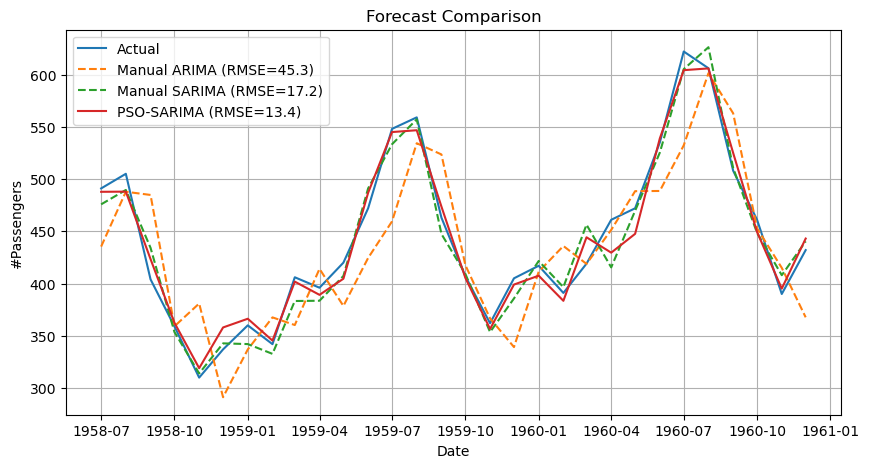

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pyswarm import pso
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
series = data['#Passengers']

# Split into train and test
test_size = 30
train, test = series[:-test_size], series[-test_size:]

# 1) Manual ARIMA(2,1,2) forecast and RMSE
history = list(train)
man_preds = []
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2)).fit()
    yhat = model.forecast()[0]
    man_preds.append(yhat)
    history.append(test.iloc[t])
man_rmse = np.sqrt(mean_squared_error(test, man_preds))
print(f"Manual ARIMA(2,1,2) RMSE: {man_rmse:.2f}")

# 2) Manual SARIMA(1,0,1)x(1,1,1,12) forecast and RMSE
history = list(train)
sarima_preds = []
for t in range(len(test)):
    model = SARIMAX(history,
                    order=(1,0,1),
                    seasonal_order=(1,1,1,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fit = model.fit(disp=False)
    yhat = fit.forecast()[0]
    sarima_preds.append(yhat)
    history.append(test.iloc[t])
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_preds))
print(f"Manual SARIMA RMSE: {sarima_rmse:.2f}")

# 3) PSO-optimized SARIMA parameters and forecast
def sarima_obj(params):
    p, d, q, P, D, Q = [int(max(0, p)) for p in params]
    try:
        fit = SARIMAX(train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
        preds = fit.forecast(steps=len(test))
        return mean_squared_error(test, preds)
    except:
        return 1e6

lb_sarima = [0,0,0,0,0,0]
ub_sarima = [3,1,3,2,1,2]
best_sarima, best_mse_sarima = pso(sarima_obj, lb_sarima, ub_sarima,
                                swarmsize=20, maxiter=30)
best_sarima = [int(x) for x in best_sarima]
print(f"PSO-SARIMA best params: {best_sarima}, Validation MSE: {best_mse_sarima:.2f}")

opt_sarima = SARIMAX(train,
                    order=tuple(best_sarima[:3]),
                    seasonal_order=(best_sarima[3], best_sarima[4], best_sarima[5], 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
sarima_opt_preds = opt_sarima.forecast(steps=len(test))
sarima_opt_rmse = np.sqrt(mean_squared_error(test, sarima_opt_preds))
print(f"Optimized SARIMA RMSE: {sarima_opt_rmse:.2f}")

# Plot comparison of Manual ARIMA, Manual SARIMA, and PSO-SARIMA
plt.figure(figsize=(10,5))
plt.plot(test.index, test,               label='Actual')
plt.plot(test.index, man_preds, '--',    label=f'Manual ARIMA (RMSE={man_rmse:.1f})')
plt.plot(test.index, sarima_preds, '--', label=f'Manual SARIMA (RMSE={sarima_rmse:.1f})')
plt.plot(test.index, sarima_opt_preds, '-', label=f'PSO-SARIMA (RMSE={sarima_opt_rmse:.1f})')
plt.legend()
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.grid(True)
plt.show()